<a href="https://colab.research.google.com/github/rpjena/random_matrix/blob/main/CUSUM_Change_Detection_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

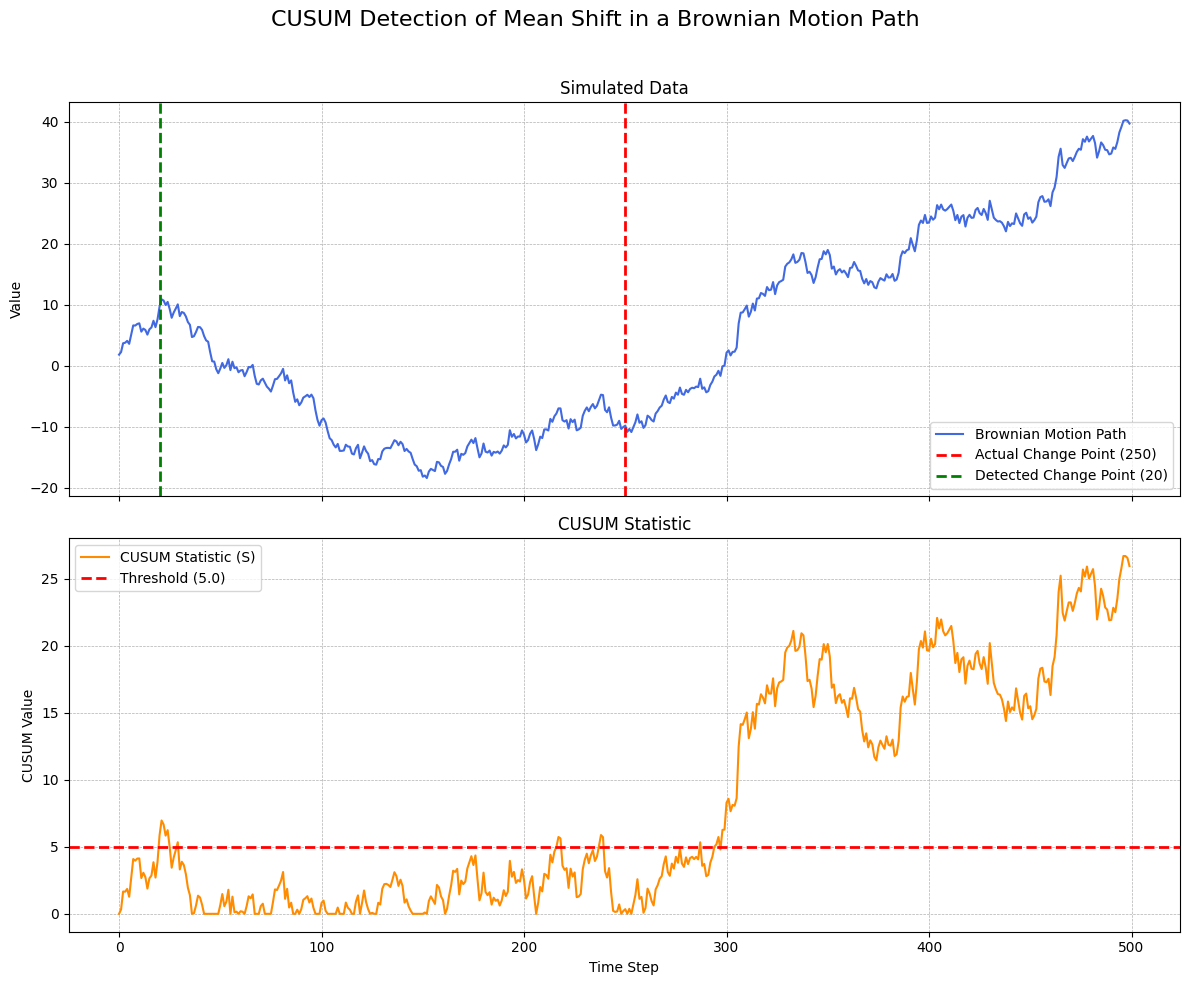

Data Generation Summary:
  - Actual change point occurs at time step: 250
------------------------------
CUSUM Algorithm Summary:
  - Change detected at time step: 20
  - Detection lag (detection - actual): -230 steps


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data_with_change(n_points_pre, n_points_post, pre_mean, post_mean_shift, std_dev=1.0):
    """
    Generates a dataset with a change in mean.

    Args:
        n_points_pre (int): Number of data points before the change.
        n_points_post (int): Number of data points after the change.
        pre_mean (float): The mean of the data before the change.
        post_mean_shift (float): The amount to shift the mean by after the change point.
        std_dev (float): The standard deviation of the data points.

    Returns:
        tuple: A tuple containing the full dataset and the index of the change point.
    """
    # Generate data before the change
    pre_change_data = np.random.normal(pre_mean, std_dev, n_points_pre)

    # Generate data after the change
    post_change_data = np.random.normal(pre_mean + post_mean_shift, std_dev, n_points_post)

    # Concatenate the data
    full_data = np.concatenate((pre_change_data, post_change_data))

    # The change point is the index where the post-change data begins
    change_point_index = n_points_pre

    return full_data, change_point_index

def cusum_change_point_detection(data, target_mean, drift, threshold):
    """
    Implements the CUSUM algorithm to detect a positive shift in the mean.

    The algorithm calculates a cumulative sum (S) of deviations from a target mean.
    A change is flagged when this sum exceeds a certain threshold.

    Formula: S_i = max(0, S_{i-1} + (x_i - target_mean - drift))

    Args:
        data (np.ndarray): The time series data to analyze.
        target_mean (float): The expected mean of the process before any change.
        drift (float): The allowable 'slack' in the process. A common choice is
                       half the magnitude of the shift you want to detect.
        threshold (float): The value the CUSUM statistic must exceed to signal a change.

    Returns:
        tuple: A tuple containing:
               - The list of CUSUM statistic values (S).
               - The index where the change was detected (-1 if no change detected).
    """
    cusum_values = [0]
    detection_index = -1

    for i in range(1, len(data)):
        # Calculate the next CUSUM value
        current_s = cusum_values[-1] + (data[i] - target_mean - drift)

        # The CUSUM value cannot be negative
        next_s = max(0, current_s)
        cusum_values.append(next_s)

        # Check if the CUSUM value has crossed the threshold
        # We only record the first time it crosses
        if next_s > threshold and detection_index == -1:
            detection_index = i

    return cusum_values, detection_index

# --- 1. Define Parameters and Generate Data ---
N_POINTS_PRE_CHANGE = 250
N_POINTS_POST_CHANGE = 250
PRE_CHANGE_MEAN = 0.0
# We will introduce a small, positive shift in the mean
POST_CHANGE_SHIFT = 0.2

# Generate the Brownian motion path by taking the cumulative sum of the random data
random_walk_data, actual_change_point = generate_data_with_change(
    N_POINTS_PRE_CHANGE,
    N_POINTS_POST_CHANGE,
    PRE_CHANGE_MEAN,
    POST_CHANGE_SHIFT
)
brownian_path = np.cumsum(random_walk_data)


# --- 2. Apply the CUSUM Algorithm ---

# CUSUM parameters
# The drift is often set to half the expected shift magnitude
CUSUM_DRIFT = POST_CHANGE_SHIFT / 2
# The threshold is a tuning parameter. A higher threshold makes the algorithm less
# sensitive to changes but reduces false positives.
CUSUM_THRESHOLD = 5.0

# Run the CUSUM algorithm on the original (non-cumulative) data
cusum_stats, detected_change_point = cusum_change_point_detection(
    random_walk_data,
    PRE_CHANGE_MEAN,
    CUSUM_DRIFT,
    CUSUM_THRESHOLD
)

# --- 3. Visualize the Results ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('CUSUM Detection of Mean Shift in a Brownian Motion Path', fontsize=16)

# Plot 1: The Brownian Motion Path
ax1.plot(brownian_path, label='Brownian Motion Path', color='royalblue')
ax1.axvline(actual_change_point, color='red', linestyle='--', linewidth=2, label=f'Actual Change Point ({actual_change_point})')
if detected_change_point != -1:
    ax1.axvline(detected_change_point, color='green', linestyle='--', linewidth=2, label=f'Detected Change Point ({detected_change_point})')
ax1.set_title('Simulated Data')
ax1.set_ylabel('Value')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot 2: The CUSUM Statistic
ax2.plot(cusum_stats, label='CUSUM Statistic (S)', color='darkorange')
ax2.axhline(CUSUM_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Threshold ({CUSUM_THRESHOLD})')
ax2.set_title('CUSUM Statistic')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('CUSUM Value')
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 4. Print Summary ---
print(f"Data Generation Summary:")
print(f"  - Actual change point occurs at time step: {actual_change_point}")
print("-" * 30)
print(f"CUSUM Algorithm Summary:")
if detected_change_point != -1:
    print(f"  - Change detected at time step: {detected_change_point}")
    print(f"  - Detection lag (detection - actual): {detected_change_point - actual_change_point} steps")
else:
    print("  - No change was detected with the given threshold.")